In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [8]:
# 读取数据
df = pd.read_excel('首尔市区4月份交通天气数据_2017-2025.xlsx')

print("数据基本信息:")
print(df.info())
print("\n前5行数据:")
print(df.head())

数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      270 non-null    object 
 1   年份      270 non-null    int64  
 2   月份      270 non-null    int64  
 3   平均速度    270 non-null    float64
 4   天气      270 non-null    object 
 5   最高温度    240 non-null    float64
 6   最低温度    240 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 14.9+ KB
None

前5行数据:
           日期    年份  月份  平均速度   天气  最高温度  最低温度
0  2017-04-01  2017   4  21.7  无数据   NaN   NaN
1  2017-04-02  2017   4  25.2  无数据   NaN   NaN
2  2017-04-03  2017   4  22.4  无数据   NaN   NaN
3  2017-04-04  2017   4  21.3  无数据   NaN   NaN
4  2017-04-05  2017   4  20.8  无数据   NaN   NaN


In [9]:
# ✅ 第二步：定义拥堵指标
def get_congestion_level(speed):
    if speed > 23:
        return 'High Speed'
    elif speed >= 20:
        return 'Medium'
    else:
        return 'Congested'

df['Congestion Level'] = df['平均速度'].apply(get_congestion_level)
df['Congestion Degree'] = 1 / df['平均速度']  # 拥堵程度与速度成反比

print("\nCongestion Level Distribution:")
print(df['Congestion Level'].value_counts())


Congestion Level Distribution:
Congestion Level
Medium        163
Congested      74
High Speed     33
Name: count, dtype: int64



Descriptive Statistics by Weather Type:
          mean       std  count   min   max
天气                                         
多云   20.617949  1.309052     39  18.1  23.5
少云   21.226531  1.712670     49  18.2  25.6
无数据  21.930000  1.538506     30  20.6  25.3
晴    21.001266  1.582719     79  18.0  25.8
阴    20.483871  1.397640     31  19.0  24.0
雨    21.168293  1.615772     41  19.1  25.6
雪    20.600000       NaN      1  20.6  20.6

Statistics by Congestion Level:
                  count       mean       std   min   25%   50%     75%   max
Congestion Level                                                            
Congested          74.0  19.359459  0.425205  18.0  19.2  19.4  19.675  19.9
High Speed         33.0  24.200000  0.802340  23.1  23.5  24.0  24.800  25.8
Medium            163.0  21.187117  0.786157  20.0  20.6  21.0  21.750  23.0


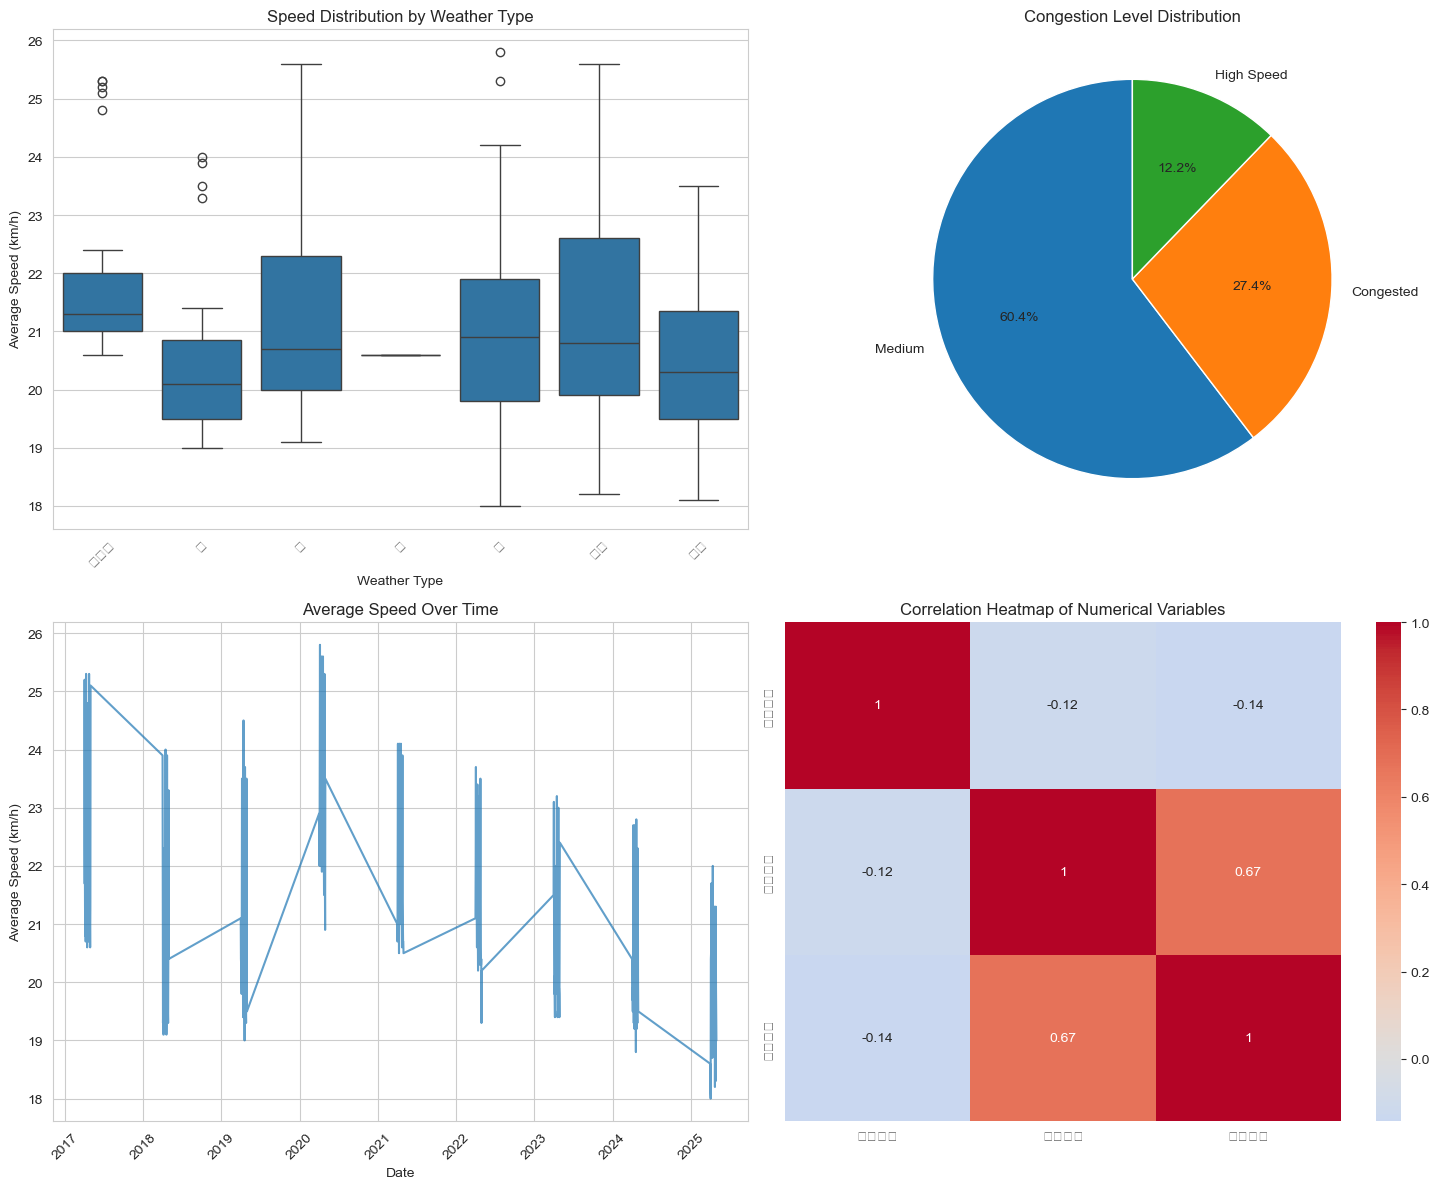


Cross Analysis: Weather Type vs Congestion Level (%):
Congestion Level  Congested  High Speed  Medium
天气                                             
多云                    35.90        5.13   58.97
少云                    26.53       14.29   59.18
无数据                    0.00       16.67   83.33
晴                     27.85       11.39   60.76
阴                     48.39       12.90   38.71
雨                     24.39       14.63   60.98
雪                      0.00        0.00  100.00


<Figure size 1200x600 with 0 Axes>

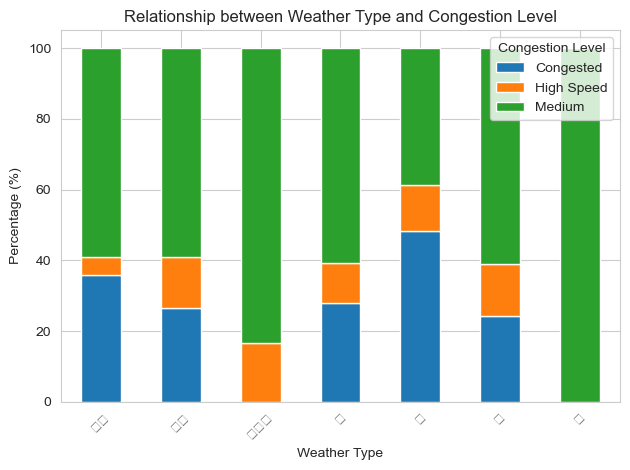

In [14]:
# ✅ 第三步：探索性分析

# 1. 描述性统计
print("\nDescriptive Statistics by Weather Type:")
weather_stats = df.groupby('天气')['平均速度'].agg(['mean', 'std', 'count', 'min', 'max'])
print(weather_stats)

# 按拥堵等级分组的统计
congestion_stats = df.groupby('Congestion Level')['平均速度'].describe()
print("\nStatistics by Congestion Level:")
print(congestion_stats)

# 2. 可视化分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 箱线图：天气类型与速度分布
sns.boxplot(data=df, x='天气', y='平均速度', ax=axes[0,0])
axes[0,0].set_title('Speed Distribution by Weather Type')
axes[0,0].set_xlabel('Weather Type')
axes[0,0].set_ylabel('Average Speed (km/h)')
axes[0,0].tick_params(axis='x', rotation=45)

# 拥堵等级分布饼图
congestion_counts = df['Congestion Level'].value_counts()
axes[0,1].pie(congestion_counts.values, labels=congestion_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Congestion Level Distribution')

# 折线图：速度随时间变化（按年份）
df['日期'] = pd.to_datetime(df['日期'])
df_sorted = df.sort_values('日期')
axes[1,0].plot(df_sorted['日期'], df_sorted['平均速度'], alpha=0.7)
axes[1,0].set_title('Average Speed Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Average Speed (km/h)')
axes[1,0].tick_params(axis='x', rotation=45)

# 热力图：相关性矩阵（数值变量）
numeric_df = df[['平均速度', '最高温度', '最低温度']].corr()
sns.heatmap(numeric_df, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Correlation Heatmap of Numerical Variables')

plt.tight_layout()
plt.show()

# 天气类型与拥堵等级交叉分析
weather_congestion = pd.crosstab(df['天气'], df['Congestion Level'], normalize='index') * 100
print("\nCross Analysis: Weather Type vs Congestion Level (%):")
print(weather_congestion.round(2))

# 可视化交叉分析
plt.figure(figsize=(12, 6))
weather_congestion.plot(kind='bar', stacked=True)
plt.title('Relationship between Weather Type and Congestion Level')
plt.xlabel('Weather Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Congestion Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# ✅ 第四步：统计检验

# 1. 方差分析 (ANOVA)
print("\n=== ANOVA Analysis ===")
weather_groups = []
for weather_type in df['天气'].unique():
    if weather_type != '无数据':  # 排除无数据
        group_data = df[df['天气'] == weather_type]['平均速度'].dropna()
        if len(group_data) > 0:
            weather_groups.append(group_data)

if len(weather_groups) >= 2:
    f_stat, p_value = f_oneway(*weather_groups)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Significant differences in average speed between weather types (p < 0.05)")
    else:
        print("No significant differences in average speed between weather types (p >= 0.05)")

# 2. 相关性分析
print("\n=== Correlation Analysis ===")

# 将天气类型编码为数值
df_encoded = df.copy()
le = LabelEncoder()
df_encoded['Weather Code'] = le.fit_transform(df_encoded['天气'])

# 计算相关系数
correlation_spearman = df_encoded[['平均速度', 'Weather Code', '最高温度', '最低温度']].corr(method='spearman')
correlation_pearson = df_encoded[['平均速度', '最高温度', '最低温度']].corr(method='pearson')

print("Spearman Correlation Coefficients:")
print(correlation_spearman.round(4))
print("\nPearson Correlation Coefficients (Numerical Variables Only):")
print(correlation_pearson.round(4))

# 3. 回归分析
print("\n=== Multiple Linear Regression Analysis ===")

# 准备回归数据（排除无数据）
regression_df = df[df['天气'] != '无数据'].copy()

# 对天气类型进行独热编码
weather_dummies = pd.get_dummies(regression_df['天气'], prefix='Weather')
regression_df = pd.concat([regression_df, weather_dummies], axis=1)

# 定义自变量和因变量
X = regression_df[['最高温度', '最低温度'] + list(weather_dummies.columns)]
y = regression_df['平均速度']

# 删除缺失值
valid_mask = X.notna().all(axis=1) & y.notna()
X = X[valid_mask]
y = y[valid_mask]

# 执行线性回归
model = LinearRegression()
model.fit(X, y)

# 输出回归结果
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"R²: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

print("\nRegression Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")



=== ANOVA Analysis ===
F-statistic: 1.4148
P-value: 0.2196
No significant differences in average speed between weather types (p >= 0.05)

=== Correlation Analysis ===
Spearman Correlation Coefficients:
                平均速度  Weather Code    最高温度    最低温度
平均速度          1.0000       -0.0294 -0.1508 -0.1424
Weather Code -0.0294        1.0000 -0.2336 -0.1159
最高温度         -0.1508       -0.2336  1.0000  0.6692
最低温度         -0.1424       -0.1159  0.6692  1.0000

Pearson Correlation Coefficients (Numerical Variables Only):
        平均速度    最高温度    最低温度
平均速度  1.0000 -0.1227 -0.1427
最高温度 -0.1227  1.0000  0.6711
最低温度 -0.1427  0.6711  1.0000

=== Multiple Linear Regression Analysis ===
R²: 0.0473
Mean Squared Error (MSE): 2.3078
Intercept: 21.5924

Regression Coefficients:
最高温度: -0.0300
最低温度: -0.0282
Weather_多云: -0.0867
Weather_少云: 0.5143
Weather_晴: 0.1827
Weather_阴: -0.2465
Weather_雨: 0.3303
Weather_雪: -0.6940



=== Random Forest Modeling ===
Random Forest R²: -0.3416
Random Forest Mean Squared Error (MSE): 2.6049

Feature Importance Ranking:
      feature  importance
1        最低温度    0.434303
0        最高温度    0.398180
3  Weather_少云    0.052835
4   Weather_晴    0.032744
6   Weather_雨    0.030810
5   Weather_阴    0.029039
2  Weather_多云    0.022089
7   Weather_雪    0.000000


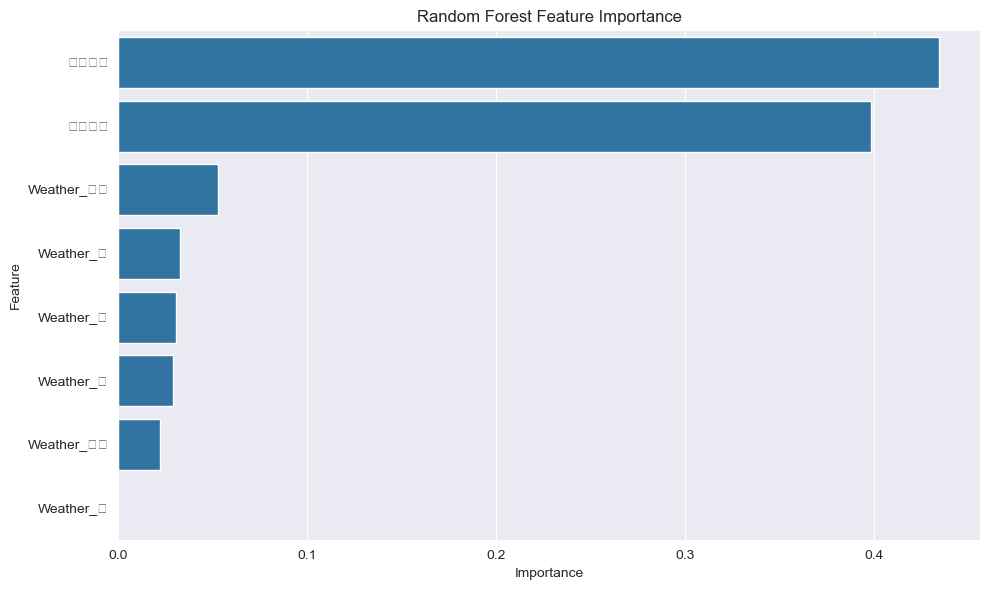


=== Speed Trends by Year ===
Average Speed by Year:
        mean    std
年份                 
2017  21.930  1.539
2018  20.480  1.503
2019  20.687  1.366
2020  23.073  1.293
2021  21.593  1.105
2022  21.263  1.063
2023  20.630  1.146
2024  20.303  1.180
2025  19.530  1.038


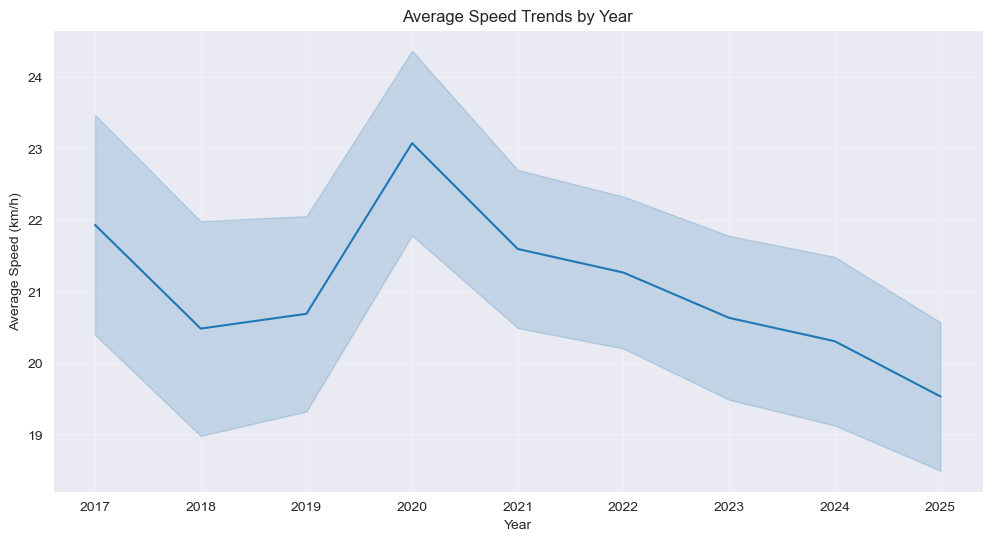


ANALYSIS SUMMARY REPORT
1. Total data points: 270 days
2. Congested days (<20 km/h): 74 days (27.4%)
3. Number of weather types: 7
4. Most congested weather: 阴 (20.48 km/h)
5. Least congested weather: 无数据 (21.93 km/h)
6. Linear regression R²: 0.0473
7. Random forest prediction R²: -0.3416


In [12]:
# ✅ 第五步：建模预测（随机森林）
print("\n=== Random Forest Modeling ===")

# 准备特征和目标变量
features = ['最高温度', '最低温度'] + list(weather_dummies.columns)
X_rf = regression_df[features]
y_rf = regression_df['平均速度']

# 删除缺失值
valid_mask_rf = X_rf.notna().all(axis=1) & y_rf.notna()
X_rf = X_rf[valid_mask_rf]
y_rf = y_rf[valid_mask_rf]

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 预测和评估
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest R²: {r2_rf:.4f}")
print(f"Random Forest Mean Squared Error (MSE): {mse_rf:.4f}")

# 特征重要性
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 额外分析：不同年份的速度趋势
print("\n=== Speed Trends by Year ===")
yearly_speed = df.groupby('年份')['平均速度'].agg(['mean', 'std']).round(3)
print("Average Speed by Year:")
print(yearly_speed)

# 可视化年份趋势
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='年份', y='平均速度', estimator='mean', errorbar='sd')
plt.title('Average Speed Trends by Year')
plt.xlabel('Year')
plt.ylabel('Average Speed (km/h)')
plt.grid(True, alpha=0.3)
plt.show()

# 总结报告
print("\n" + "="*50)
print("ANALYSIS SUMMARY REPORT")
print("="*50)
print(f"1. Total data points: {len(df)} days")
print(f"2. Congested days (<20 km/h): {len(df[df['Congestion Level'] == 'Congested'])} days ({len(df[df['Congestion Level'] == 'Congested'])/len(df)*100:.1f}%)")
print(f"3. Number of weather types: {len(df['天气'].unique())}")
print(f"4. Most congested weather: {df.groupby('天气')['平均速度'].mean().idxmin()} ({df.groupby('天气')['平均速度'].mean().min():.2f} km/h)")
print(f"5. Least congested weather: {df.groupby('天气')['平均速度'].mean().idxmax()} ({df.groupby('天气')['平均速度'].mean().max():.2f} km/h)")
print(f"6. Linear regression R²: {r2:.4f}")
print(f"7. Random forest prediction R²: {r2_rf:.4f}")
print("="*50)
